The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Adam
:label:`sec_adam`

In the discussions leading up to this section we encountered a number of techniques for efficient optimization. Let's recap them in detail here:

* We saw that :numref:`sec_sgd` is more effective than Gradient Descent when solving optimization problems, e.g., due to its inherent resilience to redundant data. 
* We saw that :numref:`sec_minibatch_sgd` affords significant additional efficiency arising from vectorization, using larger sets of observations in one minibatch. This is the key to efficient multi-machine, multi-GPU and overall parallel processing. 
* :numref:`sec_momentum` added a mechanism for aggregating a history of past gradients to accelerate convergence.
* :numref:`sec_adagrad` used per-coordinate scaling to allow for a computationally efficient preconditioner. 
* :numref:`sec_rmsprop` decoupled per-coordinate scaling from a learning rate adjustment. 

Adam :cite:`Kingma.Ba.2014` combines all these techniques into one efficient learning algorithm. As expected, this is an algorithm that has become rather popular as one of the more robust and effective optimization algorithms to use in deep learning. It is not without issues, though. In particular, :cite:`Reddi.Kale.Kumar.2019` show that there are situations where Adam can diverge due to poor variance control. In a follow-up work :citet:`Zaheer.Reddi.Sachan.ea.2018` proposed a hotfix to Adam, called Yogi which addresses these issues. More on this later. For now let's review the Adam algorithm. 

## The Algorithm

One of the key components of Adam is that it uses exponential weighted moving averages (also known as leaky averaging) to obtain an estimate of both the momentum and also the second moment of the gradient. That is, it uses the state variables

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

Here $\beta_1$ and $\beta_2$ are nonnegative weighting parameters. Common choices for them are $\beta_1 = 0.9$ and $\beta_2 = 0.999$. That is, the variance estimate moves *much more slowly* than the momentum term. Note that if we initialize $\mathbf{v}_0 = \mathbf{s}_0 = 0$ we have a significant amount of bias initially towards smaller values. This can be addressed by using the fact that $\sum_{i=0}^{t-1} \beta^i = \frac{1 - \beta^t}{1 - \beta}$ to re-normalize terms. Correspondingly the normalized state variables are given by 

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \textrm{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

Armed with the proper estimates we can now write out the update equations. First, we rescale the gradient in a manner very much akin to that of RMSProp to obtain

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

Unlike RMSProp our update uses the momentum $\hat{\mathbf{v}}_t$ rather than the gradient itself. Moreover, there is a slight cosmetic difference as the rescaling happens using $\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$ instead of $\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$. The former works arguably slightly better in practice, hence the deviation from RMSProp. Typically we pick $\epsilon = 10^{-6}$ for a good trade-off between numerical stability and fidelity. 

Now we have all the pieces in place to compute updates. This is slightly anticlimactic and we have a simple update of the form

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

Reviewing the design of Adam its inspiration is clear. Momentum and scale are clearly visible in the state variables. Their rather peculiar definition forces us to debias terms (this could be fixed by a slightly different initialization and update condition). Second, the combination of both terms is pretty straightforward, given RMSProp. Last, the explicit learning rate $\eta$ allows us to control the step length to address issues of convergence. 

## Implementation 

Implementing Adam from scratch is not very daunting. For convenience we store the time step counter $t$ in the `hyperparams` dictionary. Beyond that all is straightforward.


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

We are ready to use Adam to train the model. We use a learning rate of $\eta = 0.01$.


loss: 0.243, 0.193 sec/epoch


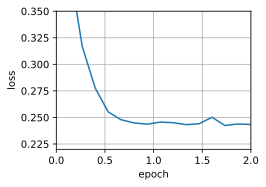

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

A more concise implementation is straightforward since `adam` is one of the algorithms provided as part of the Gluon `trainer` optimization library. Hence we only need to pass configuration parameters for an implementation in Gluon.


loss: 0.243, 0.152 sec/epoch


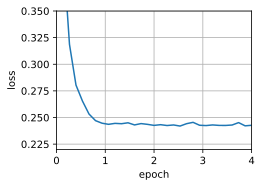

In [3]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Yogi

One of the problems of Adam is that it can fail to converge even in convex settings when the second moment estimate in $\mathbf{s}_t$ blows up. As a fix :citet:`Zaheer.Reddi.Sachan.ea.2018` proposed a refined update (and initialization) for $\mathbf{s}_t$. To understand what's going on, let's rewrite the Adam update as follows:

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

Whenever $\mathbf{g}_t^2$ has high variance or updates are sparse, $\mathbf{s}_t$ might forget past values too quickly. A possible fix for this is to replace $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$ by $\mathbf{g}_t^2 \odot \mathop{\textrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$. Now the magnitude of the update no longer depends on the amount of deviation. This yields the Yogi updates

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\textrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

The authors furthermore advise to initialize the momentum on a larger initial batch rather than just initial pointwise estimate. We omit the details since they are not material to the discussion and since even without this convergence remains pretty good.


loss: 0.243, 0.165 sec/epoch


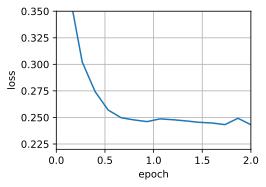

In [4]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## Summary

* Adam combines features of many optimization algorithms into a fairly robust update rule. 
* Created on the basis of RMSProp, Adam also uses EWMA on the minibatch stochastic gradient.
* Adam uses bias correction to adjust for a slow startup when estimating momentum and a second moment. 
* For gradients with significant variance we may encounter issues with convergence. They can be amended by using larger minibatches or by switching to an improved estimate for $\mathbf{s}_t$. Yogi offers such an alternative. 

## Exercises

1. Adjust the learning rate and observe and analyze the experimental results.
1. Can you rewrite momentum and second moment updates such that it does not require bias correction?
1. Why do you need to reduce the learning rate $\eta$ as we converge?
1. Try to construct a case for which Adam diverges and Yogi converges?


[Discussions](https://discuss.d2l.ai/t/1078)
